In [46]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from scipy.signal import find_peaks


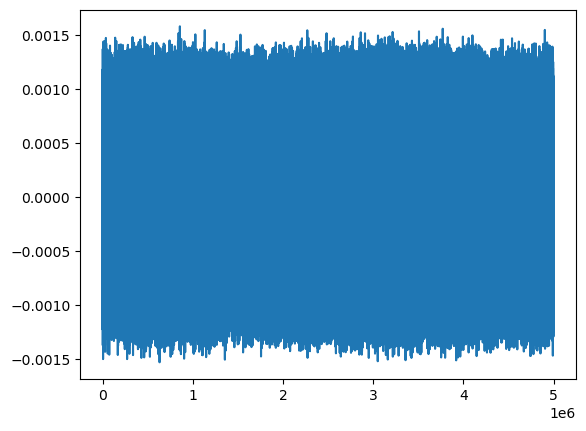

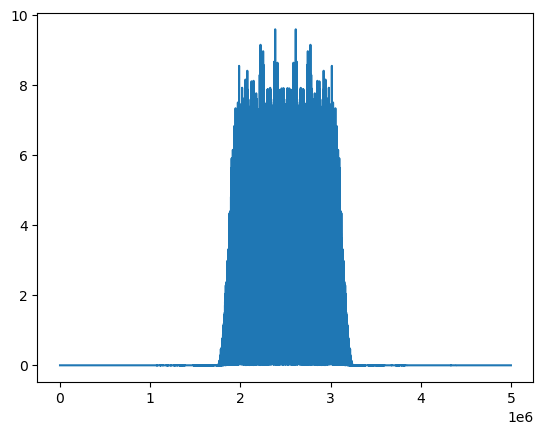

In [129]:
file_name="f433_snr20_QPSK/file_2.dat"
N=10000000
fd=open(file_name,"rb")
data=np.fromfile(fd,dtype=np.complex64,count=N)
plt.plot(np.real(data[5000000:]))
plt.show()
plt.plot(abs(np.fft.fftshift(np.fft.fft(np.real(data)[5000000:]))))

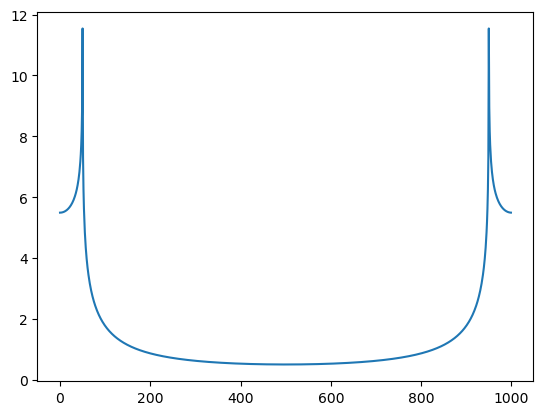

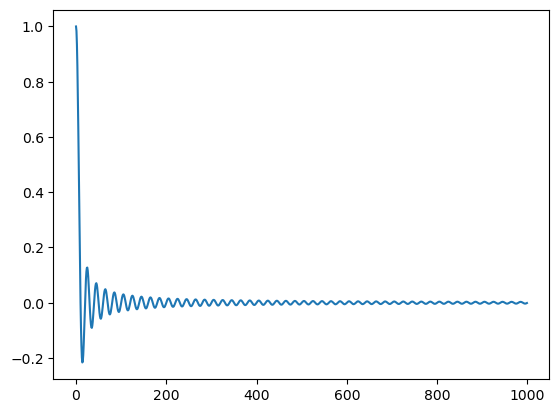

In [ ]:
#Getting IQ samples of WIFI in the form {channel_num:{[I samples],[Qsamples]}\
Wifi_symbols={1:(np.array([np.sinc(0.1*i) for i in range(100000)]),np.array([np.sinc(0.2*i) for i in range(100000)]))}

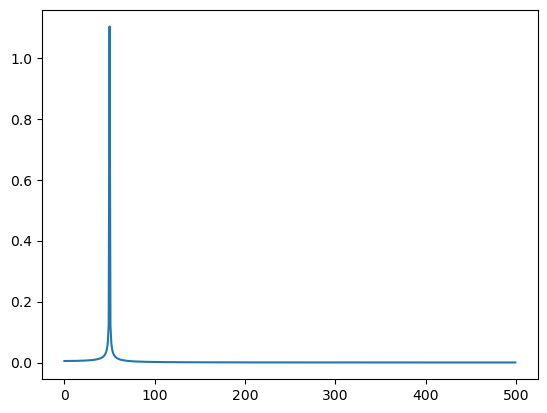

In [108]:
#Create 2-D stft array for each channel

num_samples_per_fft=1000
num_fft=100

Per_channel_time_frequency_spectrum={}

for channel in Wifi_symbols:
    Per_channel_time_frequency_spectrum[channel]={}
    I_f_t_spectrum=[]
    Q_f_t_spectrum=[]
    for i in range(num_fft):
        I_f_t_spectrum.append(abs(np.fft.fft(Wifi_symbols[channel][0][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
        Q_f_t_spectrum.append(abs(np.fft.fft(Wifi_symbols[channel][1][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
    Per_channel_time_frequency_spectrum[channel]['I']=np.array(I_f_t_spectrum)
    Per_channel_time_frequency_spectrum[channel]['Q']=np.array(Q_f_t_spectrum)

#print(Per_channel_time_frequency_spectrum)
plt.plot(Per_channel_time_frequency_spectrum[1]['I'][1])        

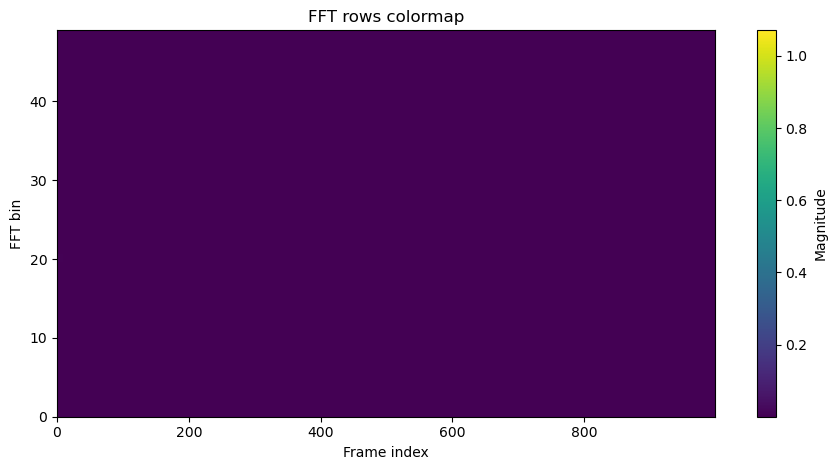

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fft_rows_colormap_freq_on_y(M, fs=None, freq_axis=None, title="FFT rows colormap",
                                     cmap="viridis", vmin=None, vmax=None, log_scale=False):
    """
    M shape: (n_rows, n_bins). Each row is an FFT over frequency bins.
    This plots frequency on Y (vertical) and row index on X (horizontal).
    """
    M = np.asarray(M)
    Mmag = np.abs(M) if np.iscomplexobj(M) else M
    Mdisp = 20*np.log10(Mmag + np.finfo(float).eps) if log_scale else Mmag

    n_rows, n_bins = Mdisp.shape

    # X-axis: row index (or time frame index)
    x = np.arange(n_rows)

    # Y-axis: frequency bins or Hz
    if freq_axis is not None:
        y = np.asarray(freq_axis)
    elif fs is not None:
        # If these are rfft bins, use 0..fs/2; for full fft use -fs/2..fs/2 accordingly
        y = np.linspace(0, fs/2, n_bins)
    else:
        y = np.arange(n_bins)

    # Transpose so that frequency (bins) maps to vertical axis as desired
    Z = Mdisp.T

    fig, ax = plt.subplots(figsize=(9, 4.8))
    im = ax.imshow(
        Z,
        aspect='auto',
        origin='lower',                   # put lowest frequency at bottom
        extent=[x[0], x[-1], y[0], y[-1]],# extent = [xmin, xmax, ymin, ymax]
        cmap=cmap, vmin=vmin, vmax=vmax,
        interpolation='nearest'
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Magnitude (dB)' if log_scale else 'Magnitude')

    ax.set_xlabel('Frame index')
    ax.set_ylabel('Frequency (Hz)' if (fs is not None or freq_axis is not None) else 'FFT bin')
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

fig,ax=plot_fft_rows_colormap_freq_on_y(Per_channel_time_frequency_spectrum[1]['I'])
plt.show()

In [49]:
#Creating 2-D arrays where we need to find period where x axis is time and y axis is frequency


# one_arr = np.zeros(100, dtype=int)  
# one_arr[57:60] = 1  

# test_array= np.zeros((100, 100), dtype=int)

# # Fill rows 0, 5, 10, ..., 95 with the one_arr pattern
# for i in range(0, 100, 10):
#     test_array[i, :] = one_arr

mean_std_dev_each_channel={}

def find_period_stats_along_rows(data):
    # data shape: (frequency bins, time samples)
    periods = []
    # Process each column as a series along frequency axis (rows)
    for col in range(data.shape[1]):
        col_data = data[:, col]
        autocorr = np.correlate(col_data, col_data, mode='full')
        mid = len(autocorr) // 2
        autocorr = autocorr[mid:]  # only positive lags
        peaks, _ = find_peaks(autocorr, distance=1)
        peaks = peaks[peaks > 0]  # exclude zero lag peak
        if len(peaks) > 0:
            #print(peaks)
            for i in range(1,len(peaks)):
                periods.append(peaks[i]-peaks[i-1])
            periods.append(peaks[0])
            #periods.append(period)
    if len(periods) == 0:
        return None, None
    
    #print(periods)
    median_period = (np.median(periods))
    std_period = np.std(periods)
    return median_period, std_period

for channel in Per_channel_time_frequency_spectrum:
    mean_std_dev_each_channel[channel]={}
    mean_std_dev_each_channel[channel]['I']=find_period_stats_along_rows(Per_channel_time_frequency_spectrum[channel]['I'])
    mean_std_dev_each_channel[channel]['Q']=find_period_stats_along_rows(Per_channel_time_frequency_spectrum[channel]['Q'])


print(mean_std_dev_each_channel)

#

{1: {'I': (6.0, 4.210663699630736), 'Q': (2.0, 0.4905533008458142)}}


In [51]:
# multi armed bandit to select next channel to scan

In [53]:
# each channel is one arm
N = 1 # number of arms
arms_with_reward = {}
arm_last_played_time = {}
arm_mean_time = {}
arm_stddev = {}
arm_rounds_played = {}
for i in range(1, N+1):
    arms_with_reward[i] = 0
    arm_last_played_time[i] = 0
    arm_mean_time[i] = (mean_std_dev_each_channel[i]['I'][0]+mean_std_dev_each_channel[i]['Q'][0])/2
    arm_stddev[i] = (mean_std_dev_each_channel[i]['I'][1]+mean_std_dev_each_channel[i]['Q'][1])/2
    arm_rounds_played[i] = 0

In [59]:
def get_reward(T, mu, t):
    reward = 1 - (T + mu*math.ceil((t-T)/mu) - t)/mu
    return (reward)

print(arm_mean_time[1])

4.0


In [61]:
def selected_arm(epsilon):
    k = random.random()
    if (k < epsilon) : 
        next_arm = random.randint(1, N)
    else:
        next_arm = max(arms_with_reward, key = arms_with_reward.get)
    return(next_arm)

In [62]:
#Getting IQ samples of WIFI in the form {channel_num:{[I samples],[Qsamples]}
Wifi_test_samples={}
Wifi_test_samples={1:{'I':np.array([np.sinc(2*np.pi*0.7*i) for i in range(100000)]),'Q':np.array([np.sinc(2*np.pi*0.3*i) for i in range(100000)])}}
minimum_dwell_samples=100
max_dwell_samples=1000

In [65]:
Wifi_output_samples={}
for channel in Wifi_test_samples:
    Wifi_output_samples[channel]={'I':[],'Q':[]}  #I am storing it in the form [sample_num,value]
epsilon = 1.0
epsilon_decay = 0.995
total_samples = 10000
cur_sample_num=0
while(cur_sample_num<total_samples):
    next_arm = selected_arm(epsilon)
    mean_time_next_arm=arm_mean_time[next_arm]
    if mean_time_next_arm<minimum_dwell_samples:
        reward_secured=np.random.random()
    else:
        reward_secured = get_reward(arm_last_played_time[next_arm], arm_mean_time[next_arm], i)
    arm_rounds_played[next_arm] += 1
    arms_with_reward[next_arm] += (reward_secured - arms_with_reward[next_arm]) / arm_rounds_played[next_arm]
    dwell_samples_next_arm=int(6*arm_stddev[next_arm])
    for i in range(dwell_samples_next_arm):
        Wifi_output_samples[next_arm]['I'].append([cur_sample_num,Wifi_test_samples[next_arm]['I'][cur_sample_num]])
        Wifi_output_samples[next_arm]['Q'].append([cur_sample_num,Wifi_test_samples[next_arm]['Q'][cur_sample_num]])
        cur_sample_num+=1
    arm_last_played_time[next_arm] = cur_sample_num
    epsilon = epsilon * epsilon_decay
    print(next_arm, " curr_time_is ", cur_sample_num, "samples")


1  curr_time_is  14 samples
1  curr_time_is  28 samples
1  curr_time_is  42 samples
1  curr_time_is  56 samples
1  curr_time_is  70 samples
1  curr_time_is  84 samples
1  curr_time_is  98 samples
1  curr_time_is  112 samples
1  curr_time_is  126 samples
1  curr_time_is  140 samples
1  curr_time_is  154 samples
1  curr_time_is  168 samples
1  curr_time_is  182 samples
1  curr_time_is  196 samples
1  curr_time_is  210 samples
1  curr_time_is  224 samples
1  curr_time_is  238 samples
1  curr_time_is  252 samples
1  curr_time_is  266 samples
1  curr_time_is  280 samples
1  curr_time_is  294 samples
1  curr_time_is  308 samples
1  curr_time_is  322 samples
1  curr_time_is  336 samples
1  curr_time_is  350 samples
1  curr_time_is  364 samples
1  curr_time_is  378 samples
1  curr_time_is  392 samples
1  curr_time_is  406 samples
1  curr_time_is  420 samples
1  curr_time_is  434 samples
1  curr_time_is  448 samples
1  curr_time_is  462 samples
1  curr_time_is  476 samples
1  curr_time_is  490 

In [64]:
print(Wifi_output_samples)

{1: {'I': [[0, 1.0], [1, 0.06870467982088993], [2, 0.021593984095902626], [3, -0.013852197745470462], [4, -0.01732764189426729], [5, -0.0004024475639221155], [6, 0.011340944806153589], [7, 0.006397992818082307], [8, -0.004986635782222365], [9, -0.007762540402917993], [10, -0.00040229197544060946], [11, 0.006121276743621539], [12, 0.0038624418552924054], [13, -0.002938364115240829], [14, -0.005025795780498379], [15, -0.00040203274150646693], [16, 0.004160647255361808], [17, 0.002816283352994912], [18, -0.0020263802805551463], [19, -0.003726579695033052], [20, -0.0004016699823763444], [21, 0.0031311997641410992], [22, 0.0022439687657858803], [23, -0.001509684949705301], [24, -0.0029664225106010135], [25, -0.00040120386631550456], [26, 0.002495738129038665], [27, 0.0018822087901688561], [28, -0.0011765648076555732], [29, -0.002466490282646442], [30, -0.0004006346095065322], [31, 0.0020636456326989052], [32, 0.0016322708596615317], [33, -0.0009436182684582891], [34, -0.002111970285876202],